<a href="https://colab.research.google.com/github/Shah12345678901/Classification-EMDS-/blob/main/Resnet_V2_RF_XGB_SVM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.model_selection import GridSearchCV

**Data Loading**

In [ ]:
PATH='/content/drive/MyDrive/Colab Notebooks/EMDS5-Original'


train_dir = os.path.join(PATH, 'Train')
validation_dir = os.path.join(PATH, 'Val')



BATCH_SIZE = 1
SIZE=299
IMG_SIZE = (SIZE,SIZE)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 672 files belonging to 21 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 168 files belonging to 21 classes.


**Data Prepration for train and test**

In [ ]:
train_batch_img=[]
train_batch_labels=[]
for img,labels in train_dataset:
  train_batch_img.append(img)
  train_batch_labels.append(labels)

In [ ]:
train_images=[]
train_labels=[]
for i in range(672):
  train_images.append(train_batch_img[i][0])
for j in range(672):
  train_labels.append(train_batch_labels[j][0])  

In [ ]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
test_batch_img=[]
test_batch_labels=[]
for img,labels in validation_dataset:
  test_batch_img.append(img)
  test_batch_labels.append(labels)

In [ ]:
test_images=[]
test_labels=[]
for i in range(168):
  test_images.append(test_batch_img[i][0])
for j in range(168):
  test_labels.append(test_batch_labels[j][0]) 

In [ ]:
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels, test_images, test_labels

In [ ]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
#One hot encode y values for neural network. 
#from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

**Downloading the pretrained model and extracting the features **

In [ ]:
from keras.applications import inception_resnet_v2
#Load model wothout classifier/fully connected layers
Resnet_model = InceptionResNetV2(weights='imagenet', include_top=True, input_shape=(299, 299, 3))

225222656/225209952 [==============================] - 1s 0us/step


In [ ]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in Resnet_model.layers:
	layer.trainable = False

In [ ]:
Resnet_model.summary()  #Trainable parameters will be 0

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

**After Extracting the Features ,Applying the ML Classifier Algorithm for Classification**

**Random Forest**

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=Resnet_model.predict(x_train)

In [ ]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
X_for_RF = features #This is our X input to RF

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 30, random_state = 42)

In [ ]:
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=30, random_state=42)

In [ ]:
#Send test data through same feature extractor process
X_test_feature = Resnet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)


In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.4583333333333333


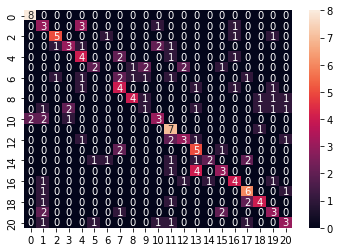

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  [12]
The actual label for this image is:  12


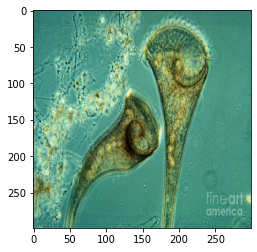

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=Resnet_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

**XGBOOST**

In [ ]:
#Now, let us use features from convolutional network for XGBOOST
feature_extractor=Resnet_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_XGBOOST = features #This is our X input to XGBOOST

In [ ]:
#XGBOOST
import xgboost as xgb
XGBOOST_model = xgb.XGBClassifier()
XGBOOST_model.fit(X_for_XGBOOST, y_train) #For sklearn no one hot encoding

XGBClassifier(objective='multi:softprob')

In [ ]:
#Send test data through same feature extractor process
X_test_feature = Resnet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained XGBOOST model. 
prediction = XGBOOST_model.predict(X_test_features)


In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.5357142857142857


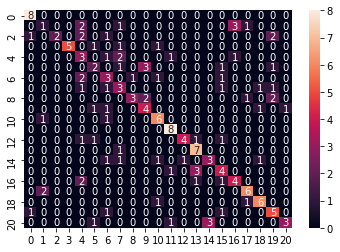

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  [8]
The actual label for this image is:  6


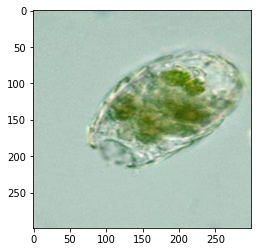

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=Resnet_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = XGBOOST_model.predict(input_img_features)[0] 
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

**SVM**

In [ ]:
from sklearn.svm import SVC

In [ ]:
#Now, let us use features from convolutional network for SVM
feature_extractor=Resnet_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to XGBOOST

In [ ]:
svc= SVC()
svc_model=svc.fit(X_for_training,y_train)

In [ ]:
#Send test data through same feature extractor process
X_test_feature = Resnet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained XGBOOST model. 
prediction = svc_model.predict(X_test_features)
